<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/P6/modules/P6/module_P6_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageShow
import cv2 as cv
import sklearn

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import layers

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


2022-06-25 20:59:33.748031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-25 20:59:33.748058: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else: print('Found GPU at: {}'.format(device_name))

GPU device not found


2022-06-25 20:59:42.407450: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-25 20:59:42.415874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vincent/devel/vjuge/oc-iml/venv/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-25 20:59:42.415904: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-25 20:59:42.415949: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rocketstation): /proc/driver/nvidia/version does not exist


## Download Dataset

In [3]:
# tfds.disable_progress_bar()

# train_ds, validation_ds, test_ds = tfds.load(
#     "stanford_dogs",
#     # Reserve 10% for validation and 10% for test
#     split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
#     as_supervised=True
# )

(train_ds, test_ds), ds_info = tfds.load(
    "stanford_dogs",
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

In [27]:
NO_BREEDS = ds_info.features['label'].num_classes

ds_info.features['label'].to_json()

{'type': 'tensorflow_datasets.core.features.class_label_feature.ClassLabel',
 'content': {'numClasses': '120'},
 'proto_cls': 'tensorflow_datasets.ClassLabel'}

In [54]:

ds_info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=120)

In [37]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

encoder = LabelBinarizer()
encoder.fit(ds_info.features['label'].names)
# print(encoder.classes_)

enc = encoder.transform(['n02085620-chihuahua', ds_info.features['label'].names[10]])

print(enc)
print(encoder.inverse_transform(enc))
# y = encoder.transform(y)


LabelBinarizer()

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
['n02085620-chihuahua' 'n02088238-basset']


Prepare the data : 

note: on peut resizer à 150 x 150, si on garde 299 x 299 (default XCeption), la ram est tout juste suffisante sur collab

le fitting peut planter :

```
Votre session a planté après avoir utilisé toute la RAM disponible.

En tant qu'abonné Colab Pro, vous disposez de plus de mémoire, mais si vous êtes intéressé par des environnements d'exécution à mémoire RAM encore plus élevée, envisagez de passer à Colab Pro+.
```



In [62]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [30]:
size = (299, 299)

train_ds = train_ds\
    .map(lambda x, y: (tf.image.resize(x, size), y))\
    .map(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS))) # transform labels to one hot encoding
    # .map(lambda x, y: (x, encoder.transform(np.array(y)))) # transform labels to one hot encoding

# validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

test_ds = test_ds\
    .map(lambda x, y: (tf.image.resize(x, size), y))\
    .map(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS))) #depth is number of classes
    # .map(lambda x, y: (x, encoder.transform(y))) # transform labels to one hot encoding

In [31]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
#validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

<Figure size 720x720 with 0 Axes>

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

2022-06-24 20:48:52.920288: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


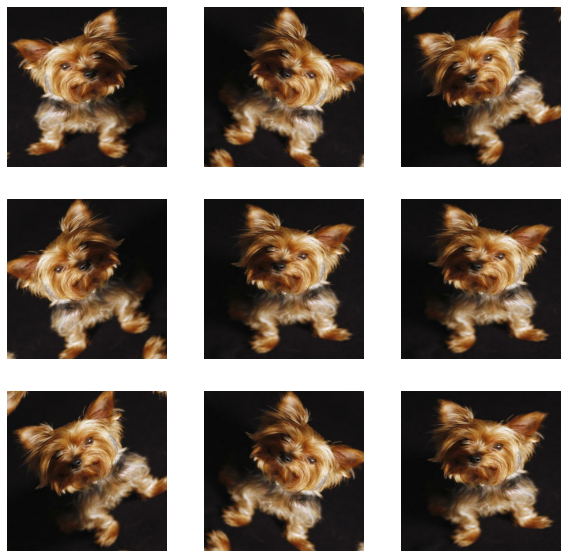

In [72]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        # plt.title(int(labels[0]))
        plt.axis("off")

In [8]:
def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

Build model

In [9]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(NO_BREEDS, activation='softmax')(x)  #120 = number of breeds
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

Train top layer

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 25
history = model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/25
375/375 [==============================] - 104s 242ms/step - loss: 1.1507 - categorical_accuracy: 0.7788 - val_loss: 0.3630 - val_categorical_accuracy: 0.9026
Epoch 2/25
375/375 [==============================] - 89s 237ms/step - loss: 0.4301 - categorical_accuracy: 0.8722 - val_loss: 0.3117 - val_categorical_accuracy: 0.9044
Epoch 3/25
375/375 [==============================] - 89s 237ms/step - loss: 0.3715 - categorical_accuracy: 0.8851 - val_loss: 0.2982 - val_categorical_accuracy: 0.9050
Epoch 4/25
375/375 [==============================] - 89s 237ms/step - loss: 0.3261 - categorical_accuracy: 0.8956 - val_loss: 0.2976 - val_categorical_accuracy: 0.9045
Epoch 5/25
375/375 [==============================] - 89s 237ms/step - loss: 0.2964 - categorical_accuracy: 0.9055 - val_loss: 0.2920 - val_categorical_accuracy: 0.9034
Epoch 6/25
375/375 [==============================] - 89s 237ms/step - loss: 0.2750 - categorical_accuracy: 0.9115 - val_loss: 0.2982 - val_categorical_ac

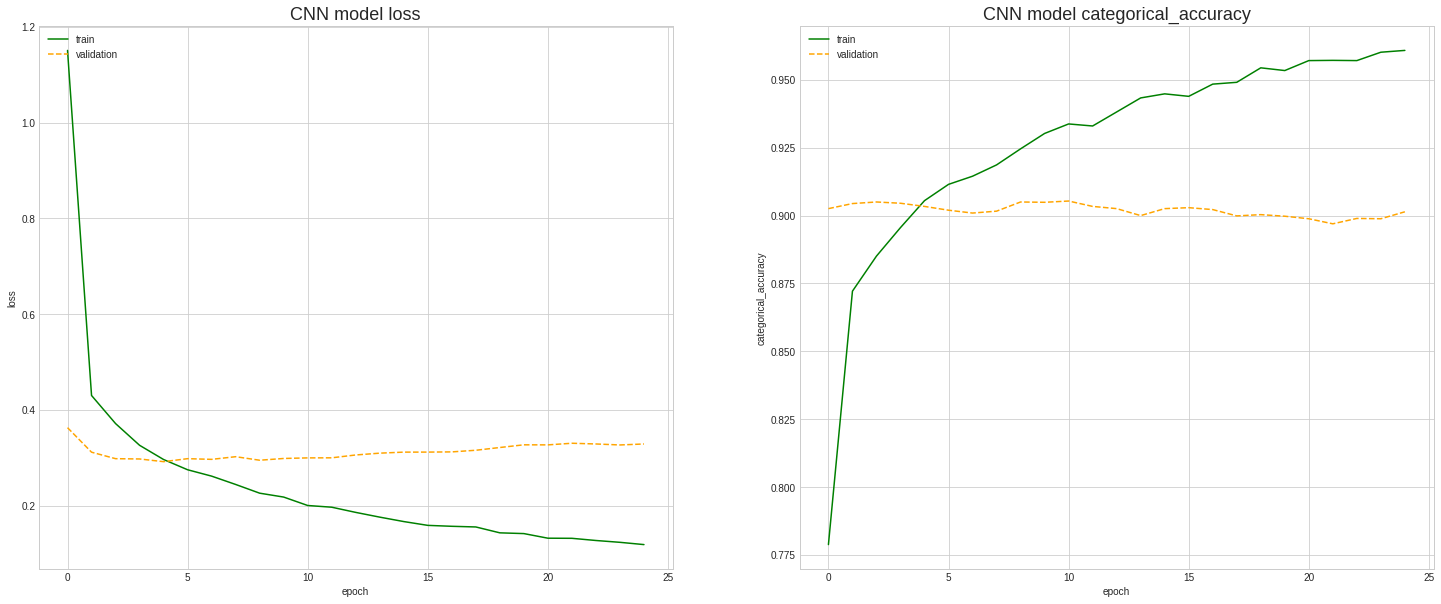

In [11]:
plot_history_scores(history, "loss", "categorical_accuracy")

In [13]:
history.model.save('xception_trained_model.h5')

In [28]:
model = tf.keras.models.load_model('xception_trained_model.h5')

In [65]:
for images, labels in test_ds.take(2):
    for i in range(labels.shape[0] -1):
        # print(labels[0])
        # print(labels[0])
        label_id = np.argmax(labels[i])
        label_name = ds_info.features['label'].names[label_id]
        # print(model(images, training=False))
        # print(tf.reduce_max(model(images, training=False)))
        found_label_id = np.argmax(model(images, training=False)[i], axis=0)
        found_label = ds_info.features['label'].names[found_label_id]
        if (label_id == found_label_id):
            found = 'ok !'
        else:
            found = ':('
        print(f'given: {label_name} --> found: {found_label} -- {found}')


given: n02102177-welsh_springer_spaniel --> found: n02102177-welsh_springer_spaniel -- ok !
given: n02106662-german_shepherd --> found: n02106662-german_shepherd -- ok !
given: n02099712-labrador_retriever --> found: n02099712-labrador_retriever -- ok !
given: n02088466-bloodhound --> found: n02088466-bloodhound -- ok !
given: n02107683-bernese_mountain_dog --> found: n02107683-bernese_mountain_dog -- ok !
given: n02093859-kerry_blue_terrier --> found: n02093859-kerry_blue_terrier -- ok !
given: n02099429-curly-coated_retriever --> found: n02099429-curly-coated_retriever -- ok !
given: n02088094-afghan_hound --> found: n02088094-afghan_hound -- ok !
given: n02102318-cocker_spaniel --> found: n02102318-cocker_spaniel -- ok !
given: n02110185-siberian_husky --> found: n02110185-siberian_husky -- ok !
given: n02088238-basset --> found: n02088238-basset -- ok !
given: n02085782-japanese_spaniel --> found: n02085782-japanese_spaniel -- ok !
given: n02100583-vizsla --> found: n02100583-vizsl

2022-06-25 22:01:12.703003: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Certaines prédictions sont fausses, en regardant des exemples de races, on constate qu'elles sont très proches ce qui peut induire le modèle en erreur.

Le modèle a confondu ces races :

coated_wheaten_terrier avec sealyham_terrier : 
![](assets/coated_wheaten_terrier.jpg) -- ![](assets/sealyham_terrier.jpg)

airedale avec lakeland_terrier:
![](assets/airedale.jpg) -- ![](assets/lakeland_terrier.jpg)

standard_poodle avec miniature_poodle
![](assets/standard_poodle.jpg) -- ![](assets/miniature_poodle.jpg)

norwegian_elkhound avec leonberg
![](assets/norwegian_elkhound.jpg) -- ![](assets/leonberg.jpg)

Il pourrait être difficile pour quelqu'un de non avisé de faire la différence.

Data augmentation:

<https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/>


### model compile

What are the choices for optimizer, loss & metrics ? : <https://keras.io/guides/training_with_built_in_methods#many-builtin-optimizers-losses-and-metrics-are-available>

* optimizers: <https://keras.io/api/optimizers/>
* Losses: <https://keras.io/api/losses/>
* Metrics: <https://keras.io/api/metrics/>



tip: in order to view GPU usage, type command: `watch -n 1 nvidia-smi`

The results are quite poor, both accuracy and loss are too low (resp. too high)

## Pre-trained model : Transfer Learning

Kera doc: <https://keras.io/guides/transfer_learning/>

deep learning with Python <https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html>

